# STFT on Keras!

by Keunwoo Choi

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import librosa
import keras

font = {'family' : 'normal',
        'weight' : 'light',
        'size'   : 11}

matplotlib.rc('font', **font)


Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


## How to DFT

Goal: compute (magnitude(STFT))$^2$ with `keras`.

Note: 
 * Discrete Fourier Transform : $\sum_{n=0}^{N-1} x(n) \exp{j \omega_k n}$ , where $\omega_k$ =  $  \frac{w \pi k}{N}$, $k=0,1,..,n-1$
    - $\sum_{n=0}^{N-1}$: `keras.layers.convolutional.Convolution1D` will do this.
    - decompose the exponential: $\exp{x} = \cos{x} + j\sin{x}$
    - So we need kernels for {real, imaginary} parts $\times$ {each frequency band}
    - which can be pre-computed as below
    

    

In [2]:
n_dft = 2**3 # which is too small but okay for 'EDUCATIONAL' purpose!
w_ks = [2*np.pi*k/float(n_dft) for k in xrange(n_dft)]
timesteps = range(n_dft)
dft_real_kernels = np.array([[np.cos(w_k*n) for n in timesteps] for w_k in w_ks])
dft_imag_kernels = np.array([[np.sin(w_k*n) for n in timesteps] for w_k in w_ks])

/Users/gnu/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


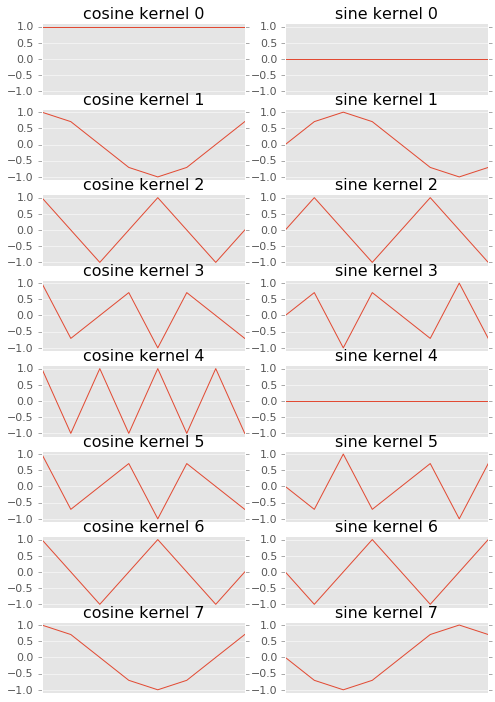

In [4]:
plt.figure(figsize=(8,12))
# real 
for kernel_idx, dft_real_kernel in enumerate(dft_real_kernels):
    plt.subplot(n_dft, 2, (2*kernel_idx)+1)
    plt.plot(dft_real_kernel)
    plt.ylim([-1.1, 1.1])
    plt.xticks([])
    plt.title('cosine kernel %d' % kernel_idx)
    
for kernel_idx, dft_imag_kernel in enumerate(dft_imag_kernels):
    plt.subplot(n_dft, 2, (2*kernel_idx)+2)
    plt.plot(dft_imag_kernel)
    plt.ylim([-1.1, 1.1])
    plt.xticks([])    
    plt.title('sine kernel %d' % kernel_idx)


Note: Given `N_FFT`, we only need `N_FFT/2+1` kernels.

## Let's take a look into keras

In [5]:
from keras.layers.convolutional import Convolution1D

In [6]:
conv1d = keras.layers.convolutional.Convolution1D(5, 8, input_shape=(44100,1), bias=False)
model = keras.models.Sequential()
model.add(conv1d)

In [7]:
print model.layers[0]
print model.layers[0].weights

[convolution1d_1_W]


In [8]:
weights = model.layers[0].get_weights()
print len(weights)
print weights[0].shape

1
(5, 1, 8, 1)


## So, it looks like...
* weights[0] should be set with our DFT kernels.
* the weights should not be trained.

## Details
are in `stft.py`. In short...
* We use each feature map channel as each frequency band.
* We use convolutional kernels as cosine/sine kernels

In [13]:
nb_filter = n_dft/2 + 1
dft_real_kernels[:nb_filter].shape
weights_real = dft_real_kernels[:nb_filter]
weights_imag = dft_imag_kernels[:nb_filter]
weights_real.shape

(5, 8)

In [14]:
# just because reshaping is always confusing.
print weights_real[1, :]

[  1.00000000e+00   7.07106781e-01   6.12323400e-17  -7.07106781e-01
  -1.00000000e+00  -7.07106781e-01  -1.83697020e-16   7.07106781e-01]


In [15]:
reshaped_w_r = weights_real[:, np.newaxis, :, np.newaxis]
print reshaped_w_r[1, 0, :, 0]
# these are used in stft.Spectrogram()

[  1.00000000e+00   7.07106781e-01   6.12323400e-17  -7.07106781e-01
  -1.00000000e+00  -7.07106781e-01  -1.83697020e-16   7.07106781e-01]


## Let's do STFT!
Again, `Spectrogram()` is implemented in `stft.py`. I will just import and use it.

In [16]:
import stft
SR = 12000 # sampling rate
duration = 8.0
len_src = SR * duration
specgram = stft.Spectrogram(n_dft=512, n_hop=128, input_shape=(len_src, 1))
src, sr = librosa.load('src/bensound-cute.mp3', sr=12000, duration=8.0)  # whole signal    
src = src[:duration*SR]
print src.shape
src_input = src[np.newaxis, :, np.newaxis]
print src_input.shape

(96000,)
(1, 96000, 1)


/Users/gnu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:
output = specgram.predict(src_input)
# now we have spectrogram!

In [18]:
print ('#sample, num_frame, num_freq')
print output.shape

#sample, num_frame, num_freq
(1, 750, 257)


In [19]:
D = librosa.logamplitude(np.abs(librosa.stft(src, n_fft=512, hop_length=128))**2, ref_power=np.max)
print D.shape
# 750 vs 751 frames: because of the edges

(257, 751)


## Verification
Let's see if it's done correctly.

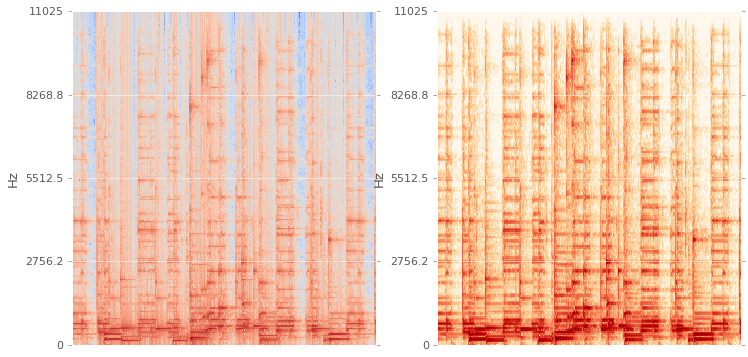

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
librosa.display.specshow(output[0].transpose(), y_axis='linear')
plt.subplot(1,2,2)
librosa.display.specshow(D, y_axis='linear')

It seems working well!

# Some notes
  1. Their scale is different, because I use `log` while librosa used `log10` for amplitude mapping. This should be fine in many use-cases because batch_normalization should be done *per frequency band* on this STFT representation.
  
  2. The whole training (as well as prediction) pipeline would be then,
    - Store all audio files as numpy format (Ok, it may occupy quite a lot of spaces. `float16` wouldn't hurt in general. ). In each batch, load them by `np.load` 
    - Or just do the same in HDF.
    - Your model will load raw audio as an input, so `Spectrogram()` should be the very first layer.
    - Probably `BatchNormalization(axis=time_axis)` should follow.
    - Then do something you want.
  
  3. Would this be any better the pre-compute STFT?
    - It can be if you want to vary things like sampling rate, num_channel, bandwidth, etc., so that you don't want to store all of them in your HDD.
    - I am not sure how it would affect the speed. The gradient does not backpropagate through this layer, so only forward-pass would be slow down due to this. 
   